<h3>Анализ рынка пассажирских авиаперевозок.</h3>

<h4>Этап I.</h4>

База данных содержит следующие колонки:
- `destination` - пункт назначения (название города на русском языке)
- `parsing_date` - дата среза (запуска скрэйпинга)
- `departure_date` - дата вылета
- `days_until` - количество календарных дней до даты вылета
- `airlines` - название авиакомпании
- `departure_time` - время вылета (по Москве)
- `arrival_time` - время прибытия (по местному времени)
- `duration_m` - время в пути в минутах
- `departure_airport` - трёхбуквенный код аэропорта отправления
- `arrival_airport` - трёхбуквенный код аэропорта прибытия
- `min_price` - стоимость билета в рублях (минимальная, так как именно она отражается на странице поиска)
- `stops_count` - число пересадок

Логика сбора данных была настроена так:
- источник: https://www.skyscanner.ru/
- ежедневный запуск
- интервал дат: 30 последовательных дней, начиная с даты, находящейся через 1 полную неделю от даты запуска (т.е. для `parsing_date = 2021-12-05` диапазон `departure_date` - от `2021-12-13` до `2022-01-12`)
- выбирались билеты, содержащие рейс(ы) только одной авиакомпании (убирался флаг поиска "комбинации авиакомпаний")
- аэропорт прибытия определялся городом, при наличии нескольких аэропортов выбирался самый популярный

In [1]:
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('seaborn')

В качестве пунктов назначения были выбраны следующие города:

In [2]:
with sqlite3.connect('sqlite.db') as con:
    cities = pd.read_sql('SELECT * FROM city', con=con)

cities

,name,airport
0,Будапешт,BUD
1,Лиссабон,LIS
2,Амстердам,AMS
3,Барселона,BCN
4,Мюнхен,MUC
5,Рим,FCO
6,Вена,VIE
7,Краков,KRK
8,Прага,PRG
9,Копенгаген,CPH


In [3]:
with sqlite3.connect('sqlite.db') as con:
    data = pd.read_sql('SELECT * FROM flight', con=con)
    
data

,destination,parsing_date,departure_date,days_until,airlines,departure_time,arrival_time,duration_m,departure_airport,arrival_airport,min_price,stops_count
0,Будапешт,2021-11-28,2021-12-06,8,Wizz Air,11:05,11:45,160,VKO,BUD,17970,0
1,Будапешт,2021-11-28,2021-12-06,8,Aeroflot,14:05,14:55,170,SVO,BUD,17160,0
2,Будапешт,2021-11-28,2021-12-06,8,LOT,14:20,17:25,305,SVO,BUD,13019,1
3,Будапешт,2021-11-28,2021-12-06,8,Turkish Airlines,02:40,08:30,470,VKO,BUD,9097,1
4,Будапешт,2021-11-28,2021-12-06,8,KLM,17:55,23:05,430,SVO,BUD,13728,1
...,...,...,...,...,...,...,...,...,...,...,...,...
338746,Марсель,2021-12-05,2022-01-12,38,Air France,10:15,21:30,2235,SVO,MRS,18196,2
338747,Марсель,2021-12-05,2022-01-12,38,Lufthansa,16:15,12:45,1350,DME,MRS,31020,2
338748,Марсель,2021-12-05,2022-01-12,38,TAROM,09:05,17:40,2075,SVO,MRS,48848,2
338749,Марсель,2021-12-05,2022-01-12,38,Etihad Airways,15:50,17:40,1670,SVO,MRS,117157,2


Проверка на значения типа `None | numpy.NaN`:

In [4]:
data.isna().sum().sum()

0

Какие есть срезы данных на текущий момент?

In [5]:
pd.DataFrame(data['parsing_date'].unique())

,0
0,2021-11-28
1,2021-11-29
2,2021-11-30
3,2021-12-01
4,2021-12-02
5,2021-12-04
6,2021-12-05


Распределение числа пересадок:

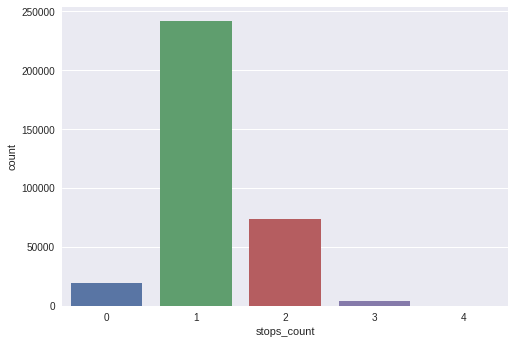

In [6]:
_ = sns.countplot(x=data['stops_count'])

Популярность городов:

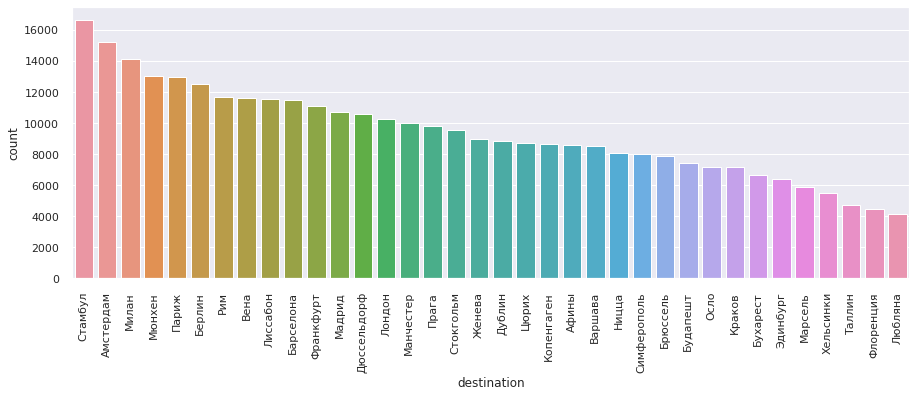

In [7]:
sns.set(rc={'figure.figsize': (15, 5)})
_ = sns.countplot(x=data['destination'], order=data['destination'].value_counts().index)
_.set_xticklabels(_.get_xticklabels(), rotation=90);

Статистики по числовым переменным:

In [8]:
data.describe()

,days_until,duration_m,min_price,stops_count
count,338751.000000,338751.000000,338751.000000,338751.000000
mean,23.322739,977.464624,38936.087274,1.185357
std,8.791345,539.731338,35703.331427,0.538752
min,8.000000,110.000000,2485.000000,0.000000
25%,16.000000,550.000000,16393.000000,1.000000
50%,23.000000,895.000000,27920.000000,1.000000
75%,31.000000,1345.000000,46837.000000,1.000000
max,38.000000,5895.000000,672851.000000,4.000000


Разница в распределении цены для разных авиакомпаний:

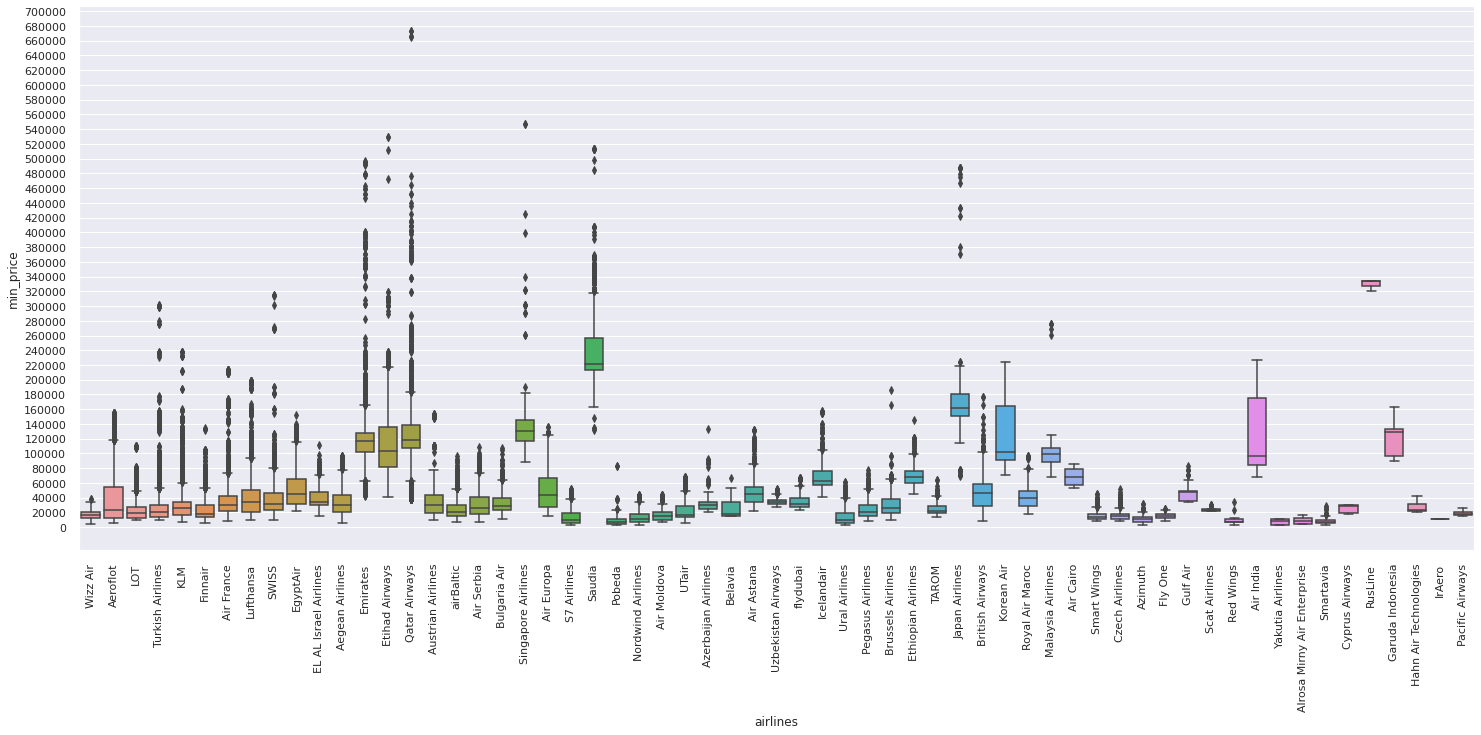

In [9]:
sns.set(rc={'figure.figsize': (25, 10)})
_ = sns.boxplot(x='airlines', y='min_price', data=data)
_.set_xticklabels(_.get_xticklabels(), rotation=90)
start, end = _.get_ylim()
_.yaxis.set_ticks(np.arange(0, end, 20_000));

Тут нужно не забывать, что дело не только в идентичности авикомпании, а в том числе и в географии рейсов в рамках данного датасэта, что тоже сильно влияет на цены.

Также видно, что есть выбросы.

In [10]:
outliers = data[data['min_price'] > 150_000]
outliers

,destination,parsing_date,departure_date,days_until,airlines,departure_time,arrival_time,duration_m,departure_airport,arrival_airport,min_price,stops_count
243,Рим,2021-11-28,2021-12-06,8,Saudia,20:20,13:35,2595,SVO,FCO,185139,2
667,Лондон,2021-11-28,2021-12-06,8,Saudia,18:45,13:00,1275,SVO,LHR,222203,2
668,Лондон,2021-11-28,2021-12-06,8,Saudia,08:40,07:30,1550,SVO,LHR,218004,2
1088,Женева,2021-11-28,2021-12-06,8,Saudia,18:45,13:40,1255,SVO,GVA,341466,2
1309,Будапешт,2021-11-28,2021-12-10,12,Japan Airlines,18:25,18:30,1565,SVO,BUD,156985,2
...,...,...,...,...,...,...,...,...,...,...,...,...
338574,Марсель,2021-12-05,2022-01-06,32,Etihad Airways,15:50,10:45,1255,SVO,MRS,210706,2
338575,Марсель,2021-12-05,2022-01-06,32,Etihad Airways,15:50,14:35,1485,SVO,MRS,210593,2
338639,Марсель,2021-12-05,2022-01-08,34,Etihad Airways,15:50,22:45,1975,SVO,MRS,225591,2
338666,Марсель,2021-12-05,2022-01-09,35,Etihad Airways,15:50,10:45,1255,SVO,MRS,218132,2


In [11]:
outliers.shape[0] / data.shape[0]

0.015025785901739036

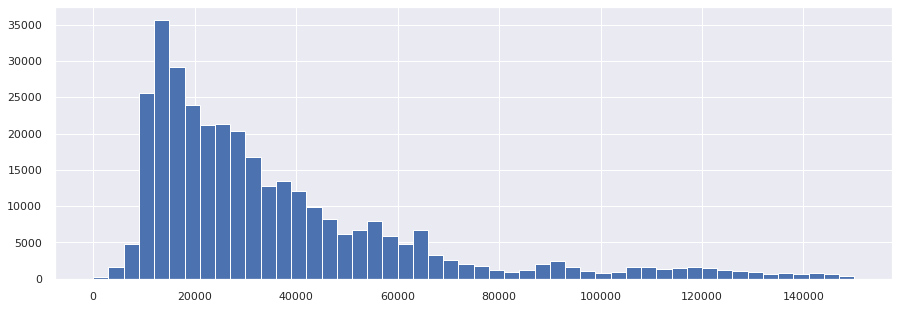

In [12]:
sns.set(rc={'figure.figsize': (15, 5)})
_ = plt.hist(data['min_price'], bins=50, range=(0, 150_000))

Можно использовать логарифмирование и предсказывать логарифм цены.

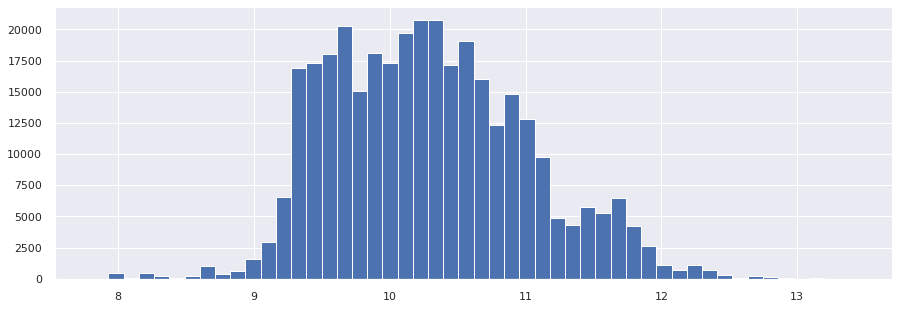

In [13]:
data['log_price'] = np.log(data['min_price'])
_ = plt.hist(data['log_price'], bins=50)

Интересно посмотреть, есть ли выраженная зависимость цены от дня недели. Интуитивно кажется, что должна быть.

In [14]:
data['departure_date'] = data['departure_date'].apply(pd.to_datetime)
data['weekday'] = data['departure_date'].dt.weekday + 1  # Monday = 1, Sunday = 7

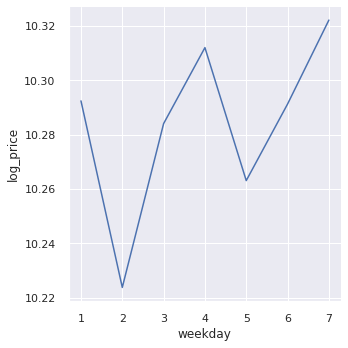

In [15]:
_ = sns.relplot(
    data=data.groupby(by='weekday')['log_price'].aggregate('mean'),
    kind='line'
)

Вполне себе ярко выраженная зависимость есть. `weekday` - потенциальный категориальный регрессор.

Час вылета также представляет интерес.

In [16]:
data['hour'] = data['departure_time'].apply(lambda x: int(x.split(':')[0]))

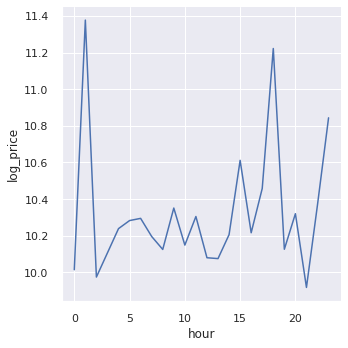

In [17]:
_ = sns.relplot(
    data=data.groupby(by='hour')['log_price'].aggregate('mean'),
    kind='line'
)

Может быть полезным.

Ещё есть предположение, что `days_until` будет значимым признаком, так как цена явно должна зависеть от количества оставшихся до рейса дней.

А что оказалось или не оказалось значимым, и получилась ли вообще какая-то рабочая модель, мы узнаем в следующем этапе.